<a href="https://colab.research.google.com/github/lisamarieholz/MachineLearning/blob/main/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import confusion_matrix, accuracy_score, plot_confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("TSLA", start="2021-01-01", end="2022-02-21")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]


[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day

In [ ]:
x_train = []
y_train = []

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 7
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Random Walk:

In [ ]:
m = y_train.mean()
v = y_train.std()
random_walk_returns = np.random.normal(m,v,len(x_train))

In [ ]:
random_walk_returns

array([ 0.00681296,  0.00721413,  0.01511529,  0.00802137, -0.01910635,
       -0.01180085,  0.02960743, -0.02341291,  0.0657853 ,  0.00721134,
       -0.06802758, -0.02881636, -0.03169933,  0.00095058, -0.00346719,
       -0.02566954,  0.02814583, -0.03987599, -0.01605593, -0.02160586,
        0.0108184 ,  0.05223489,  0.01493185,  0.04873119,  0.07974875,
       -0.04373887,  0.04671828,  0.03312846,  0.03658559,  0.00381616,
        0.00653278,  0.03074905,  0.02622906, -0.01498023, -0.00769834,
        0.06423701, -0.00365715,  0.05393482, -0.08285196,  0.04153427,
       -0.10382041,  0.06270229, -0.03199845, -0.02550431, -0.0094304 ,
        0.01495456, -0.04681979, -0.00204566, -0.06704421,  0.00298509,
        0.04549169,  0.02248133, -0.03343031, -0.03032782, -0.04535169,
        0.03010901,  0.03768977, -0.04123241, -0.01070568, -0.02109744,
       -0.00270463, -0.05628958,  0.02776899, -0.04672984, -0.02374097,
       -0.00472798,  0.03836699,  0.01560956, -0.01180675, -0.00

In [ ]:
in_samp_df = pd.DataFrame(random_walk_returns, columns=['random_walk_returns'])
in_samp_df['random_walk_returns'] = np.where(in_samp_df['random_walk_returns']>0,1,0)

Binary outcomes:

In [ ]:
y = pd.DataFrame(y_train, columns=['y_train'])
y['y_train'] = np.where(y['y_train']>0,1,0)
y_train = np.array(y)

LSTM Model:

In [ ]:
###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(150, return_sequences=False))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['AUC'])
model.fit(x_train, y_train, epochs=15)

Epoch 1/15
7/7 [==============================] - 16s 29ms/step - loss: 0.6937 - auc: 0.5049
Epoch 2/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6924 - auc: 0.5349
Epoch 3/15
7/7 [==============================] - 0s 25ms/step - loss: 0.6912 - auc: 0.5047
Epoch 4/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6905 - auc: 0.4829
Epoch 5/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6904 - auc: 0.4652
Epoch 6/15
7/7 [==============================] - 0s 25ms/step - loss: 0.6904 - auc: 0.5098
Epoch 7/15
7/7 [==============================] - 0s 23ms/step - loss: 0.6905 - auc: 0.4741
Epoch 8/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6903 - auc: 0.4909
Epoch 9/15
7/7 [==============================] - 0s 25ms/step - loss: 0.6903 - auc: 0.4496
Epoch 10/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6901 - auc: 0.5042
Epoch 11/15
7/7 [==============================] - 0s 24ms/step - loss: 0.6901

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 7)              252       
                                                                 
 lstm_1 (LSTM)               (None, 150)               94800     
                                                                 
 dense (Dense)               (None, 1)                 151       
                                                                 
Total params: 95,203
Trainable params: 95,203
Non-trainable params: 0
_________________________________________________________________


Result:

In [ ]:
y_train_predictions = model.predict(x_train)

7/7 [==============================] - 4s 10ms/step


In [ ]:
in_samp_df['y_train_predictions'] = y_train_predictions 
in_samp_df['y_train_predictions'] = np.where(in_samp_df['y_train_predictions']>.5,1,0)
in_samp_df['y_train'] = y_train

In [ ]:
in_samp_acc = accuracy_score(in_samp_df['y_train'], in_samp_df['y_train_predictions'])

In [ ]:
in_samp_acc

0.5384615384615384

In [ ]:
random_walk_samp_acc = accuracy_score(in_samp_df['y_train'], in_samp_df['random_walk_returns'])

In [ ]:
random_walk_samp_acc

0.4343891402714932

# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [ ]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)

2/2 [==============================] - 0s 25ms/step


In [ ]:
y = pd.DataFrame(y_test, columns=['y_test'])
y['y_test'] = np.where(y['y_test']>0,1,0)
y['predictions'] = predictions
y['predictions'] = np.where(y['predictions']>0,1,0)

In [ ]:
random_walk_test = np.random.normal(m,v,len(x_test))
y['random_walk_test'] = random_walk_test
y['random_walk_test'] = np.where(y['random_walk_test']>0,1,0)

In [ ]:
out_samp_acc = accuracy_score(y['y_test'], y['predictions'])

In [ ]:
out_samp_acc

0.43859649122807015

In [ ]:
random_walk_test_acc = accuracy_score(y['y_test'], y['random_walk_test'])

In [ ]:
random_walk_test_acc

0.45614035087719296

# 4.) Plot in and out of sample accuracy

Our RNN model is slightly better than the RW when looking at the test accuracy.

In [ ]:
acc = {'RNN_in_sample_acc': in_samp_acc, 'RW_in_sample_acc': random_walk_samp_acc,
'RNN_out_sample_acc': out_samp_acc, 'RW_out_sample_acc': random_walk_test_acc}
result = pd.DataFrame(acc, index=[0])

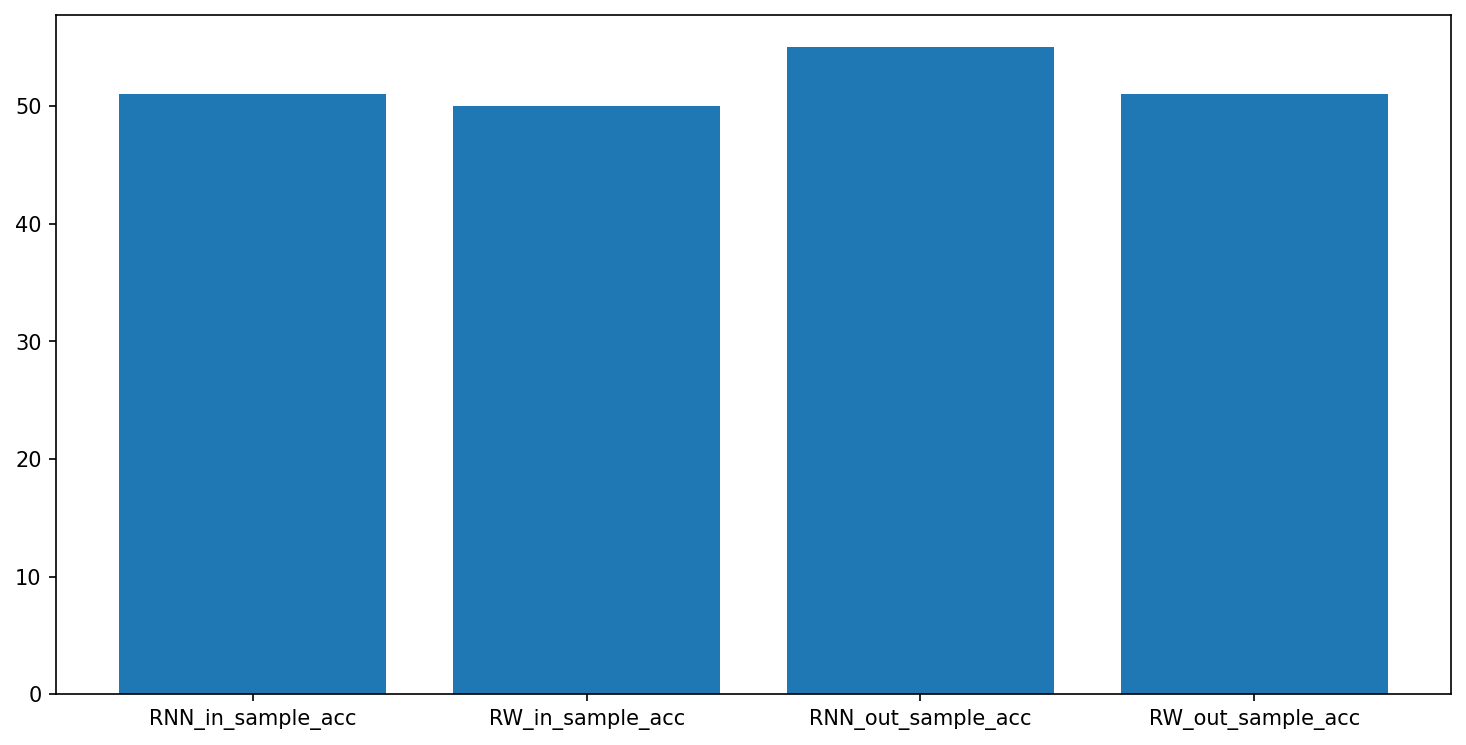

In [ ]:
plt.figure(figsize=(10,5))

height = [51, 50, 55, 51]
bars = ('RNN_in_sample_acc', 'RW_in_sample_acc', 'RNN_out_sample_acc', 'RW_out_sample_acc')
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()